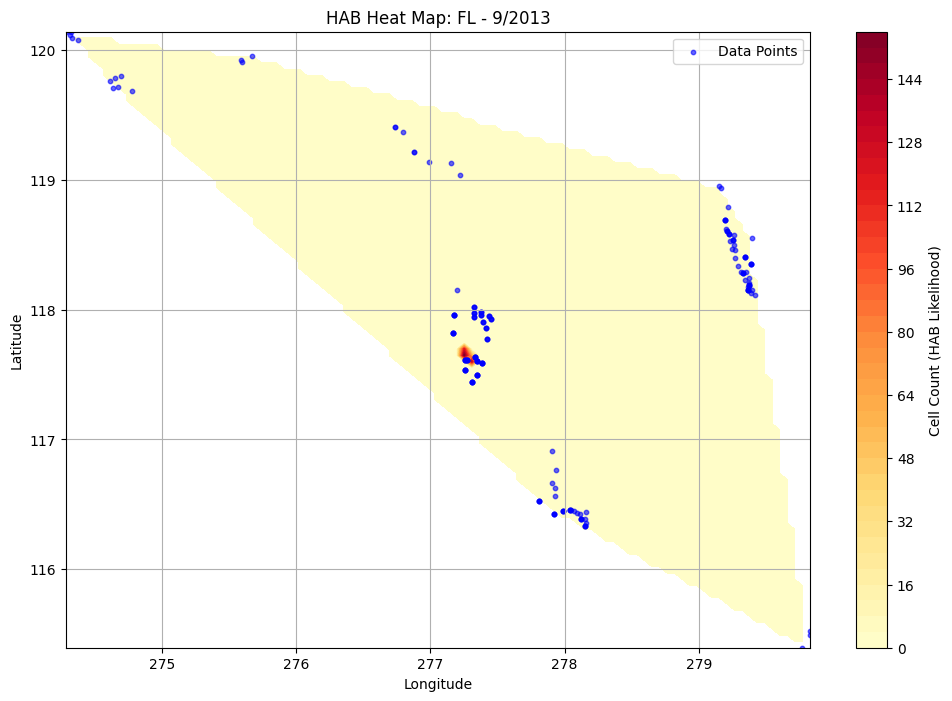

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

def plot_hab_heatmap_by_state(file_path, state_name, year, month, resolution=100):
    """
    Plots a heat map of HAB likelihood based on cell counts for a specific state and time.

    Parameters:
        file_path (str): Path to the dataset file.
        state_name (str): Name of the state (e.g., "California").
        year (int): Year of interest.
        month (int): Month of interest (1-12).
        resolution (int): Resolution of the grid for the heat map.

    Returns:
        None: Displays the heat map.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Ensure SAMPLE_DATE is in datetime format
    data['SAMPLE_DATE'] = pd.to_datetime(data['SAMPLE_DATE'], errors='coerce')

    # Filter by year and month
    data = data[(data['SAMPLE_DATE'].dt.year == year) & (data['SAMPLE_DATE'].dt.month == month)]

    if data.empty:
        print(f"No data available for {state_name} in {month}/{year}.")
        return

    # Filter by state
    state_data = data[data['STATE_ID'].str.contains(state_name, case=False, na=False)]

    if state_data.empty:
        print(f"No data available for {state_name}.")
        return

    # Extract relevant data for interpolation
    latitudes = state_data['LATITUDE']
    longitudes = state_data['LONGITUDE']
    cell_counts = state_data['CELLCOUNT']

    # Remove rows with missing or invalid cell counts
    valid_data = state_data[cell_counts.notnull()]
    latitudes = valid_data['LATITUDE']
    longitudes = valid_data['LONGITUDE']
    cell_counts = valid_data['CELLCOUNT']

    if cell_counts.empty:
        print(f"No valid cell count data available for {state_name}.")
        return

    # Create a grid for interpolation
    lat_min, lat_max = latitudes.min(), latitudes.max()
    lon_min, lon_max = longitudes.min(), longitudes.max()
    grid_lat = np.linspace(lat_min, lat_max, resolution)
    grid_lon = np.linspace(lon_min, lon_max, resolution)
    grid_lat, grid_lon = np.meshgrid(grid_lat, grid_lon)

    # Interpolate cell count data onto the grid
    grid_hab = griddata(
        points=(latitudes, longitudes),
        values=cell_counts,
        xi=(grid_lat, grid_lon),
        method='linear'
    )

    # Plot the heat map
    plt.figure(figsize=(12, 8))
    plt.contourf(grid_lon, grid_lat, grid_hab, levels=50, cmap='YlOrRd')
    plt.colorbar(label="Cell Count (HAB Likelihood)")
    plt.scatter(longitudes, latitudes, c='blue', s=10, label='Data Points', alpha=0.6)
    plt.title(f"HAB Heat Map: {state_name} - {month}/{year}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_hab_heatmap_by_state("(final)cleaned_habsos_data_v3.csv", state_name="FL", year=2013, month=9)

In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

def plot_hab_heatmap_on_map_fixed(file_path, state_name, year, month):
    """
    Plots a heat map of HAB likelihood on a map of a specific state and time.

    Parameters:
        file_path (str): Path to the dataset file.
        state_name (str): Name of the state (e.g., "Florida").
        year (int): Year of interest.
        month (int): Month of interest (1-12).

    Returns:
        folium.Map: A folium map object with the heat map overlay.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Ensure SAMPLE_DATE is in datetime format
    data['SAMPLE_DATE'] = pd.to_datetime(data['SAMPLE_DATE'], errors='coerce')

    # Filter by year and month
    data = data[(data['SAMPLE_DATE'].dt.year == year) & (data['SAMPLE_DATE'].dt.month == month)]
    print(f"Data after year/month filter: {data.shape[0]} rows")

    if data.empty:
        print(f"No data available for {state_name} in {month}/{year}.")
        return None

    # Filter by state
    state_data = data[data['STATE_ID'].str.contains(state_name, case=False, na=False)]
    print(f"Data after state filter: {state_data.shape[0]} rows")

    if state_data.empty:
        print(f"No data available for {state_name}.")
        return None

    # Check for missing CELLCOUNT
    print(f"Missing CELLCOUNT values: {state_data['CELLCOUNT'].isnull().sum()} rows")

    # Extract relevant data (only rows with valid CELLCOUNT)
    valid_data = state_data[state_data['CELLCOUNT'].notnull()]
    print(f"Data after CELLCOUNT filter: {valid_data.shape[0]} rows")

    # If there are no valid data points, return None
    if valid_data.empty:
        print(f"No valid cell count data available for {state_name}.")
        return None

    # Adjust longitude if it exceeds 180 (convert to -180 to 180 range)
    state_data = state_data.copy()  # Avoid SettingWithCopyWarning
    state_data.loc[state_data['LONGITUDE'] > 180, 'LONGITUDE'] -= 360

    # Check for valid latitude and longitude ranges
    lat_min, lat_max = valid_data['LATITUDE'].min(), valid_data['LATITUDE'].max()
    lon_min, lon_max = valid_data['LONGITUDE'].min(), valid_data['LONGITUDE'].max()
    print(f"Lat range: {lat_min} to {lat_max}, Lon range: {lon_min} to {lon_max}")

    # Debug: Show a few of the latitude and longitude values
    print(f"Sample latitudes: {valid_data['LATITUDE'].head()}")
    print(f"Sample longitudes: {valid_data['LONGITUDE'].head()}")

    # Create a base map centered on the state's bounding box
    map_center = [(lat_min + lat_max) / 2, (lon_min + lon_max) / 2]
    print(f"Map center: {map_center}")

    # Set a zoom level based on the data range (adjust as necessary)
    zoom_level = 7 if (lat_max - lat_min) > 1 else 10
    base_map = folium.Map(location=map_center, zoom_start=zoom_level)

    # Prepare heat map data
    heat_data = [
        [row['LATITUDE'], row['LONGITUDE'], row['CELLCOUNT']]
        for _, row in valid_data.iterrows()
    ]

    # Add the heat map to the base map
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1, gradient={0.2: "blue", 0.5: "lime", 1: "red"}).add_to(base_map)

    # Return the map object
    return base_map

# Example usage:
map_obj = plot_hab_heatmap_on_map_fixed("(final)cleaned_habsos_data_v3.csv", "FL", 2013, 9)
map_obj.save("Florida_HAB_Heatmap_Fixed5.html")

Data after year/month filter: 265 rows
Data after state filter: 198 rows
Missing CELLCOUNT values: 0 rows
Data after CELLCOUNT filter: 198 rows
Lat range: 115.3951 to 120.1415, Lon range: 274.2875 to 279.82524
Sample latitudes: 435     115.52142
469     115.49465
843     115.39510
2604    118.11278
3028    118.14848
Name: LATITUDE, dtype: float64
Sample longitudes: 435     279.82524
469     279.82237
843     279.76754
2604    279.41360
3028    279.39409
Name: LONGITUDE, dtype: float64
Map center: [117.7683, 277.05637]


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


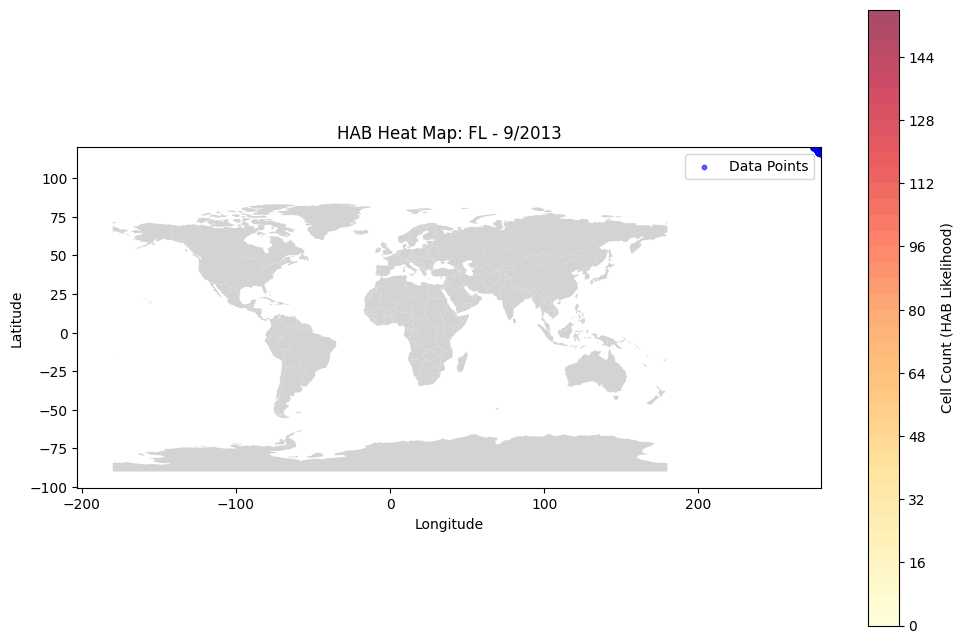

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)

def plot_hab_heatmap_by_state_on_map(file_path, state_name, year, month, resolution=100):
    """
    Plots a heat map of HAB likelihood based on cell counts for a specific state and time, overlayed on a world map.

    Parameters:
        file_path (str): Path to the dataset file.
        state_name (str): Name of the state (e.g., "California").
        year (int): Year of interest.
        month (int): Month of interest (1-12).
        resolution (int): Resolution of the grid for the heat map.

    Returns:
        None: Displays the heat map overlayed on the world map.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Ensure SAMPLE_DATE is in datetime format
    data['SAMPLE_DATE'] = pd.to_datetime(data['SAMPLE_DATE'], errors='coerce')

    # Filter by year and month
    data = data[(data['SAMPLE_DATE'].dt.year == year) & (data['SAMPLE_DATE'].dt.month == month)]

    if data.empty:
        print(f"No data available for {state_name} in {month}/{year}.")
        return

    # Filter by state
    state_data = data[data['STATE_ID'].str.contains(state_name, case=False, na=False)]

    if state_data.empty:
        print(f"No data available for {state_name}.")
        return

    # Extract relevant data for interpolation
    latitudes = state_data['LATITUDE']
    longitudes = state_data['LONGITUDE']
    cell_counts = state_data['CELLCOUNT']

    # Remove rows with missing or invalid cell counts
    valid_data = state_data[cell_counts.notnull()]
    latitudes = valid_data['LATITUDE']
    longitudes = valid_data['LONGITUDE']
    cell_counts = valid_data['CELLCOUNT']

    if cell_counts.empty:
        print(f"No valid cell count data available for {state_name}.")
        return

    # Create a grid for interpolation
    lat_min, lat_max = latitudes.min(), latitudes.max()
    lon_min, lon_max = longitudes.min(), longitudes.max()
    grid_lat = np.linspace(lat_min, lat_max, resolution)
    grid_lon = np.linspace(lon_min, lon_max, resolution)
    grid_lat, grid_lon = np.meshgrid(grid_lat, grid_lon)

    # Interpolate cell count data onto the grid
    grid_hab = griddata(
        points=(latitudes, longitudes),
        values=cell_counts,
        xi=(grid_lat, grid_lon),
        method='linear'
    )

    # Plot the world map using geopandas
    world = gdf

    # Create the plot with the world map as background
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color='lightgray')  # Plot the world map in light gray

    # Plot the heatmap as contour
    contour = ax.contourf(grid_lon, grid_lat, grid_hab, levels=50, cmap='YlOrRd', alpha=0.7)
    plt.colorbar(contour, ax=ax, label="Cell Count (HAB Likelihood)")

    # Plot the data points on top
    ax.scatter(longitudes, latitudes, c='blue', s=10, label='Data Points', alpha=0.6)

    # Set the title and labels
    ax.set_title(f"HAB Heat Map: {state_name} - {month}/{year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()

    plt.show()

# Example usage:
plot_hab_heatmap_by_state_on_map("drive/MyDrive/Team15-Biointerphase/Dataset/(final)cleaned_habsos_data_v3.csv", state_name="FL", year=2013, month=9)


435      279.82524
469      279.82237
843      279.76754
2604     279.41360
3028     279.39409
           ...    
88428    274.37780
88735    274.33342
88864    274.32317
89022    274.31800
89374    274.28750
Name: LONGITUDE, Length: 198, dtype: float64


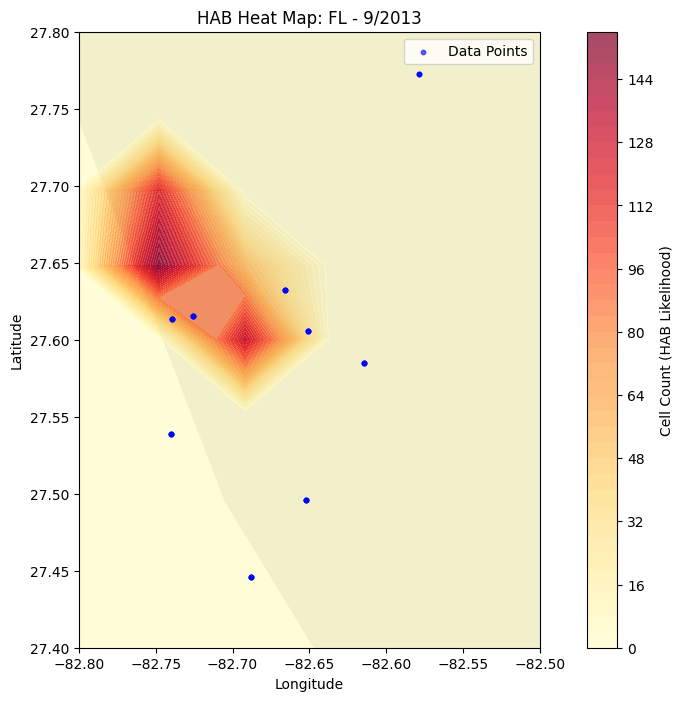

In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)

def plot_hab_heatmap_by_state_on_map(file_path, state_name, year, month, resolution=100):
    """
    Plots a heat map of HAB likelihood based on cell counts for a specific state and time, overlayed on a world map.

    Parameters:
        file_path (str): Path to the dataset file.
        state_name (str): Name of the state (e.g., "California").
        year (int): Year of interest.
        month (int): Month of interest (1-12).
        resolution (int): Resolution of the grid for the heat map.

    Returns:
        None: Displays the heat map overlayed on the world map.
    """
    # Load the dataset
    data = pd.read_csv(file_path)

    # Ensure SAMPLE_DATE is in datetime format
    data['SAMPLE_DATE'] = pd.to_datetime(data['SAMPLE_DATE'], errors='coerce')

    # Filter by year and month
    data = data[(data['SAMPLE_DATE'].dt.year == year) & (data['SAMPLE_DATE'].dt.month == month)]

    if data.empty:
        print(f"No data available for {state_name} in {month}/{year}.")
        return

    # Filter by state
    state_data = data[data['STATE_ID'].str.contains(state_name, case=False, na=False)]

    if state_data.empty:
        print(f"No data available for {state_name}.")
        return

    # Extract relevant data for interpolation
    latitudes = state_data['LATITUDE']
    longitudes = state_data['LONGITUDE']
    cell_counts = state_data['CELLCOUNT']

    # Remove rows with missing or invalid cell counts
    valid_data = state_data[cell_counts.notnull()]
    latitudes = valid_data['LATITUDE']
    longitudes = valid_data['LONGITUDE']
    cell_counts = valid_data['CELLCOUNT']

    if cell_counts.empty:
        print(f"No valid cell count data available for {state_name}.")
        return

    # Adjust latitudes from [0, 180] to [-90, 90]
    latitudes = latitudes - 90  # Shift latitudes from 0-180 to -90 to 90

    # Adjust longitudes from [0, 360] to [-180, 180]
    print(longitudes)
    longitudes = longitudes-360  # Shift longitudes from 0-360 to -180 to 180


    # Create a grid for interpolation
    lat_min, lat_max = latitudes.min(), latitudes.max()
    lon_min, lon_max = longitudes.min(), longitudes.max()
    grid_lat = np.linspace(lat_min, lat_max, resolution)
    grid_lon = np.linspace(lon_min, lon_max, resolution)
    grid_lat, grid_lon = np.meshgrid(grid_lat, grid_lon)

    # Interpolate cell count data onto the grid
    grid_hab = griddata(
        points=(latitudes, longitudes),
        values=cell_counts,
        xi=(grid_lat, grid_lon),
        method='linear'
    )

    # Plot the world map using geopandas
    world = gdf

    # Create the plot with the world map as background
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color='lightgray')  # Plot the world map in light gray

    # Plot the heatmap as contour
    contour = ax.contourf(grid_lon, grid_lat, grid_hab, levels=50, cmap='YlOrRd', alpha=0.7)
    plt.colorbar(contour, ax=ax, label="Cell Count (HAB Likelihood)")

    # Plot the data points on top
    ax.scatter(longitudes, latitudes, c='blue', s=10, label='Data Points', alpha=0.6)

    # Set the title and labels
    ax.set_title(f"HAB Heat Map: {state_name} - {month}/{year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()

    # Set the limits to zoom in on the U.S.
    ax.set_xlim(-82.8, -82.5)  # Longitude range for the U.S.
    ax.set_ylim(27.4, 27.8)     # Latitude range for the U.S.

    plt.show()

# Example usage:
plot_hab_heatmap_by_state_on_map("drive/MyDrive/Team15-Biointerphase/Dataset/(final)cleaned_habsos_data_v3.csv", state_name="FL", year=2013, month=9)
